In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
%matplotlib inline

In [94]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [95]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']), ignore_index=True)

## Imputation of missing values ##

In [96]:
# I have no idea how to do it better. Probably, it is better to do nothing
x = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotArea"]
y = all_data.loc[np.logical_not(all_data["LotFrontage"].isnull()), "LotFrontage"]
# plt.scatter(x, y)
t = (x <= 25000) & (y <= 150)
p = np.polyfit(x[t], y[t], 1)
all_data.loc[all_data['LotFrontage'].isnull(), 'LotFrontage'] = np.polyval(p, all_data.loc[all_data['LotFrontage'].isnull(), 'LotArea'])

There are many features were NaN should be considered as absence of such property. In other cases I replace NaN with most common value

In [97]:
all_data.loc[all_data.Alley.isnull(), 'Alley'] = 'NoAlley'
all_data.loc[all_data.MasVnrType.isnull(), 'MasVnrType'] = 'None' # no good
all_data.loc[all_data.MasVnrType == 'None', 'MasVnrArea'] = 0
all_data.loc[all_data.BsmtQual.isnull(), 'BsmtQual'] = 'NoBsmt'
all_data.loc[all_data.BsmtCond.isnull(), 'BsmtCond'] = 'NoBsmt'
all_data.loc[all_data.BsmtExposure.isnull(), 'BsmtExposure'] = 'NoBsmt'
all_data.loc[all_data.BsmtFinType1.isnull(), 'BsmtFinType1'] = 'NoBsmt'
all_data.loc[all_data.BsmtFinType2.isnull(), 'BsmtFinType2'] = 'NoBsmt'
all_data.loc[all_data.BsmtFinType1=='NoBsmt', 'BsmtFinSF1'] = 0
all_data.loc[all_data.BsmtFinType2=='NoBsmt', 'BsmtFinSF2'] = 0
all_data.loc[all_data.BsmtFinSF1.isnull(), 'BsmtFinSF1'] = all_data.BsmtFinSF1.median()
all_data.loc[all_data.BsmtQual=='NoBsmt', 'BsmtUnfSF'] = 0
all_data.loc[all_data.BsmtUnfSF.isnull(), 'BsmtUnfSF'] = all_data.BsmtUnfSF.median()
all_data.loc[all_data.BsmtQual=='NoBsmt', 'TotalBsmtSF'] = 0
all_data.loc[all_data.FireplaceQu.isnull(), 'FireplaceQu'] = 'NoFireplace'
all_data.loc[all_data.GarageType.isnull(), 'GarageType'] = 'NoGarage'
all_data.loc[all_data.GarageFinish.isnull(), 'GarageFinish'] = 'NoGarage'
all_data.loc[all_data.GarageQual.isnull(), 'GarageQual'] = 'NoGarage'
all_data.loc[all_data.GarageCond.isnull(), 'GarageCond'] = 'NoGarage'
all_data.loc[all_data.BsmtFullBath.isnull(), 'BsmtFullBath'] = 0
all_data.loc[all_data.BsmtHalfBath.isnull(), 'BsmtHalfBath'] = 0
all_data.loc[all_data.KitchenQual.isnull(), 'KitchenQual'] = 'TA'
all_data.loc[all_data.MSZoning.isnull(), 'MSZoning'] = 'RL'
all_data.loc[all_data.Utilities.isnull(), 'Utilities'] = 'AllPub'
all_data.loc[all_data.Exterior1st.isnull(), 'Exterior1st'] = 'VinylSd'
all_data.loc[all_data.Exterior2nd.isnull(), 'Exterior2nd'] = 'VinylSd'
all_data.loc[all_data.Functional.isnull(), 'Functional'] = 'Typ'
all_data.loc[all_data.SaleCondition.isnull(), 'SaleCondition'] = 'Normal'
all_data.loc[all_data.SaleCondition.isnull(), 'SaleType'] = 'WD'
all_data.loc[all_data['PoolQC'].isnull(), 'PoolQC'] = 'NoPool'
all_data.loc[all_data['Fence'].isnull(), 'Fence'] = 'NoFence'
all_data.loc[all_data['MiscFeature'].isnull(), 'MiscFeature'] = 'None'
all_data.loc[all_data['Electrical'].isnull(), 'Electrical'] = 'SBrkr'
# only one is null and it has type Detchd
all_data.loc[all_data['GarageArea'].isnull(), 'GarageArea'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageArea'].mean()
all_data.loc[all_data['GarageCars'].isnull(), 'GarageCars'] = all_data.loc[all_data['GarageType']=='Detchd', 'GarageCars'].median()

## Normalization ##

In [98]:
# where we have order we will use numeric
all_data = all_data.replace({'Utilities': {'AllPub': 1, 'NoSeWa': 0, 'NoSewr': 0, 'ELO': 0},
                             'Street': {'Pave': 1, 'Grvl': 0 },
                             'FireplaceQu': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoFireplace': 0 
                                            },
                             'Fence': {'GdPrv': 2, 
                                       'GdWo': 2, 
                                       'MnPrv': 1, 
                                       'MnWw': 1,
                                       'NoFence': 0},
                             'ExterQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1
                                            },
                             'ExterCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1
                                            },
                             'BsmtQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoBsmt': 0},
                             'BsmtExposure': {'Gd': 3, 
                                            'Av': 2, 
                                            'Mn': 1,
                                            'No': 0,
                                            'NoBsmt': 0},
                             'BsmtCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoBsmt': 0},
                             'GarageQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoGarage': 0},
                             'GarageCond': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1,
                                            'NoGarage': 0},
                             'KitchenQual': {'Ex': 5, 
                                            'Gd': 4, 
                                            'TA': 3, 
                                            'Fa': 2,
                                            'Po': 1},
                             'Functional': {'Typ': 0,
                                            'Min1': 1,
                                            'Min2': 1,
                                            'Mod': 2,
                                            'Maj1': 3,
                                            'Maj2': 4,
                                            'Sev': 5,
                                            'Sal': 6}                             
                            })

In [99]:
newer_dwelling = all_data.MSSubClass.replace({20: 1, 
                                            30: 0, 
                                            40: 0, 
                                            45: 0,
                                            50: 0, 
                                            60: 1,
                                            70: 0,
                                            75: 0,
                                            80: 0,
                                            85: 0,
                                            90: 0,
                                           120: 1,
                                           150: 0,
                                           160: 0,
                                           180: 0,
                                           190: 0})
newer_dwelling.name = 'newer_dwelling'

In [100]:
all_data = all_data.replace({'MSSubClass': {20: 'SubClass_20', 
                                            30: 'SubClass_30', 
                                            40: 'SubClass_40', 
                                            45: 'SubClass_45',
                                            50: 'SubClass_50', 
                                            60: 'SubClass_60',
                                            70: 'SubClass_70',
                                            75: 'SubClass_75',
                                            80: 'SubClass_80',
                                            85: 'SubClass_85',
                                            90: 'SubClass_90',
                                           120: 'SubClass_120',
                                           150: 'SubClass_150',
                                           160: 'SubClass_160',
                                           180: 'SubClass_180',
                                           190: 'SubClass_190'}})

In [101]:
# The idea is good quality should rise price, poor quality - reduce price
overall_poor_qu = all_data.OverallQual.copy()
overall_poor_qu = 5 - overall_poor_qu
overall_poor_qu[overall_poor_qu<0] = 0
overall_poor_qu.name = 'overall_poor_qu'

overall_good_qu = all_data.OverallQual.copy()
overall_good_qu = overall_good_qu - 5
overall_good_qu[overall_good_qu<0] = 0
overall_good_qu.name = 'overall_good_qu'

overall_poor_cond = all_data.OverallCond.copy()
overall_poor_cond = 5 - overall_poor_cond
overall_poor_cond[overall_poor_cond<0] = 0
overall_poor_cond.name = 'overall_poor_cond'

overall_good_cond = all_data.OverallCond.copy()
overall_good_cond = overall_good_cond - 5
overall_good_cond[overall_good_cond<0] = 0
overall_good_cond.name = 'overall_good_cond'

exter_poor_qu = all_data.ExterQual.copy()
exter_poor_qu[exter_poor_qu<3] = 1
exter_poor_qu[exter_poor_qu>=3] = 0
exter_poor_qu.name = 'exter_poor_qu'

exter_good_qu = all_data.ExterQual.copy()
exter_good_qu[exter_good_qu<=3] = 0
exter_good_qu[exter_good_qu>3] = 1
exter_good_qu.name = 'exter_good_qu'

exter_poor_cond = all_data.ExterCond.copy()
exter_poor_cond[exter_poor_cond<3] = 1
exter_poor_cond[exter_poor_cond>=3] = 0
exter_poor_cond.name = 'exter_poor_cond'

exter_good_cond = all_data.ExterCond.copy()
exter_good_cond[exter_good_cond<=3] = 0
exter_good_cond[exter_good_cond>3] = 1
exter_good_cond.name = 'exter_good_cond'

bsmt_poor_cond = all_data.BsmtCond.copy()
bsmt_poor_cond[bsmt_poor_cond<3] = 1
bsmt_poor_cond[bsmt_poor_cond>=3] = 0
bsmt_poor_cond.name = 'bsmt_poor_cond'

bsmt_good_cond = all_data.BsmtCond.copy()
bsmt_good_cond[bsmt_good_cond<=3] = 0
bsmt_good_cond[bsmt_good_cond>3] = 1
bsmt_good_cond.name = 'bsmt_good_cond'

garage_poor_qu = all_data.GarageQual.copy()
garage_poor_qu[garage_poor_qu<3] = 1
garage_poor_qu[garage_poor_qu>=3] = 0
garage_poor_qu.name = 'garage_poor_qu'

garage_good_qu = all_data.GarageQual.copy()
garage_good_qu[garage_good_qu<=3] = 0
garage_good_qu[garage_good_qu>3] = 1
garage_good_qu.name = 'garage_good_qu'

garage_poor_cond = all_data.GarageCond.copy()
garage_poor_cond[garage_poor_cond<3] = 1
garage_poor_cond[garage_poor_cond>=3] = 0
garage_poor_cond.name = 'garage_poor_cond'

garage_good_cond = all_data.GarageCond.copy()
garage_good_cond[garage_good_cond<=3] = 0
garage_good_cond[garage_good_cond>3] = 1
garage_good_cond.name = 'garage_good_cond'

kitchen_poor_qu = all_data.KitchenQual.copy()
kitchen_poor_qu[kitchen_poor_qu<3] = 1
kitchen_poor_qu[kitchen_poor_qu>=3] = 0
kitchen_poor_qu.name = 'kitchen_poor_qu'

kitchen_good_qu = all_data.KitchenQual.copy()
kitchen_good_qu[kitchen_good_qu<=3] = 0
kitchen_good_qu[kitchen_good_qu>3] = 1
kitchen_good_qu.name = 'kitchen_good_qu'

qu_list = pd.concat((overall_poor_qu, overall_good_qu, overall_poor_cond, overall_good_cond, exter_poor_qu,
                     exter_good_qu, exter_poor_cond, exter_good_cond, bsmt_poor_cond, bsmt_good_cond, garage_poor_qu,
                     garage_good_qu, garage_poor_cond, garage_good_cond, kitchen_poor_qu, kitchen_good_qu), axis=1)

bad_heating = all_data.HeatingQC.replace({'Ex': 0, 
                                          'Gd': 0, 
                                          'TA': 0, 
                                          'Fa': 1,
                                          'Po': 1})
bad_heating.name = 'bad_heating'
                                          
MasVnrType_Any = all_data.MasVnrType.replace({'BrkCmn': 1,
                                              'BrkFace': 1,
                                              'CBlock': 1,
                                              'Stone': 1,
                                              'None': 0})
MasVnrType_Any.name = 'MasVnrType_Any'

SaleCondition_PriceDown = all_data.SaleCondition.replace({'Abnorml': 1,
                                                          'Alloca': 1,
                                                          'AdjLand': 1,
                                                          'Family': 1,
                                                          'Normal': 0,
                                                          'Partial': 0})
SaleCondition_PriceDown.name = 'SaleCondition_PriceDown'

Neighborhood_Good = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Neighborhood_Good'])
Neighborhood_Good[all_data.Neighborhood=='NridgHt'] = 1
Neighborhood_Good[all_data.Neighborhood=='Crawfor'] = 1
Neighborhood_Good[all_data.Neighborhood=='StoneBr'] = 1
Neighborhood_Good[all_data.Neighborhood=='Somerst'] = 1
Neighborhood_Good[all_data.Neighborhood=='NoRidge'] = 1

# do smth with BsmtFinType1, BsmtFinType2

I have no idea what to do with Exterior1st, Exterior2nd, RoofMatl, Condition1, Condition2, BldgType. I'll try convert them into some kind of price brackets

In [102]:
from sklearn.svm import SVC

svm = SVC(C=100)
# price categories
pc = pd.Series(np.zeros(train.shape[0]))
pc[:] = 'pc1'
pc[train.SalePrice >= 150000] = 'pc2'
pc[train.SalePrice >= 220000] = 'pc3'
columns_for_pc = ['Exterior1st', 'Exterior2nd', 'RoofMatl', 'Condition1', 'Condition2', 'BldgType']
X_t = pd.get_dummies(train.loc[:, columns_for_pc])
svm.fit(X_t, pc)
pc_pred = svm.predict(X_t)


(array([ 13., 125., 183.,  94.,  40.,  16.,   3.,   3.,   1.,   2.]),
 array([0.379 , 1.0961, 1.8132, 2.5303, 3.2474, 3.9645, 4.6816, 5.3987,
        6.1158, 6.8329, 7.55  ]),
 <a list of 10 Patch objects>)

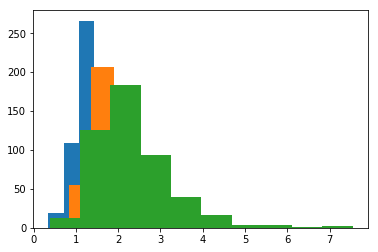

In [103]:
p = train.SalePrice/100000
plt.hist(p[pc_pred=='pc1'])
plt.hist(p[pc_pred=='pc2'])
plt.hist(p[pc_pred=='pc3'])

In [104]:
price_category = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['pc'])
X_t = pd.get_dummies(all_data.loc[:, columns_for_pc])
pc_pred = svm.predict(X_t)
price_category[pc_pred=='pc2'] = 1
price_category[pc_pred=='pc3'] = 2


In [105]:
# Monthes with the lagest number of deals may be significant
season = all_data.MoSold.replace( {1: 0, 
                                   2: 0, 
                                   3: 0, 
                                   4: 1,
                                   5: 1, 
                                   6: 1,
                                   7: 1,
                                   8: 0,
                                   9: 0,
                                  10: 0,
                                  11: 0,
                                  12: 0})
season.name = 'season'

# Numer month is not significant
all_data = all_data.replace({'MoSold': {1: 'Yan', 
                                        2: 'Feb', 
                                        3: 'Mar', 
                                        4: 'Apr',
                                        5: 'May', 
                                        6: 'Jun',
                                        7: 'Jul',
                                        8: 'Avg',
                                        9: 'Sep',
                                        10: 'Oct',
                                        11: 'Nov',
                                        12: 'Dec'}})

In [106]:
all_data.CentralAir

0       Y
1       Y
2       Y
3       Y
4       Y
5       Y
6       Y
7       Y
8       Y
9       Y
10      Y
11      Y
12      Y
13      Y
14      Y
15      Y
16      Y
17      Y
18      Y
19      Y
20      Y
21      Y
22      Y
23      Y
24      Y
25      Y
26      Y
27      Y
28      Y
29      N
       ..
2889    Y
2890    Y
2891    N
2892    N
2893    N
2894    Y
2895    Y
2896    Y
2897    Y
2898    Y
2899    Y
2900    Y
2901    Y
2902    Y
2903    Y
2904    Y
2905    Y
2906    Y
2907    Y
2908    Y
2909    Y
2910    Y
2911    Y
2912    Y
2913    Y
2914    Y
2915    Y
2916    Y
2917    Y
2918    Y
Name: CentralAir, Length: 2919, dtype: object

In [107]:
all_data = all_data.replace({'CentralAir': {'Y': 1, 
                                            'N': 0}})
all_data = all_data.replace({'PavedDrive': {'Y': 1, 
                                            'P': 0,
                                            'N': 0}})

In [108]:
reconstruct = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Reconstruct'])
reconstruct[all_data.YrSold < all_data.YearRemodAdd] = 1

recon_after_buy = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['ReconstructAfterBuy'])
recon_after_buy[all_data.YearRemodAdd >= all_data.YrSold] = 1

build_eq_buy = pd.DataFrame(np.zeros((all_data.shape[0],1)), columns=['Build.eq.Buy'])
build_eq_buy[all_data.YearBuilt >= all_data.YrSold] = 1


In [109]:
# I hope this will help
all_data.YrSold = 2010 - all_data.YrSold

In [110]:
year_map = pd.concat(pd.Series('YearGroup' + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))
all_data.GarageYrBlt = all_data.GarageYrBlt.map(year_map)
all_data.loc[all_data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 'NoGarage'

In [111]:
all_data.YearBuilt = all_data.YearBuilt.map(year_map)
all_data.YearRemodAdd = all_data.YearRemodAdd.map(year_map)

Scaling numeric data

In [112]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

t = all_data[numeric_feats].quantile(.95)
use_max_scater = t[t == 0].index
use_95_scater = t[t != 0].index
all_data[use_max_scater] = all_data[use_max_scater]/all_data[use_max_scater].max()
all_data[use_95_scater] = all_data[use_95_scater]/all_data[use_95_scater].quantile(.95)

In [113]:
t = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
     '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
     'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

all_data.loc[:, t] = np.log1p(all_data.loc[:, t])

## Preparing for sklearn##

In [117]:
# all classes in sklearn requires numeric data only
# transform categorical variable into binary
X = pd.get_dummies(all_data)
X = X.fillna(0)


In [118]:
X.RoofMatl_ClyTile

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
2889    0
2890    0
2891    0
2892    0
2893    0
2894    0
2895    0
2896    0
2897    0
2898    0
2899    0
2900    0
2901    0
2902    0
2903    0
2904    0
2905    0
2906    0
2907    0
2908    0
2909    0
2910    0
2911    0
2912    0
2913    0
2914    0
2915    0
2916    0
2917    0
2918    0
Name: RoofMatl_ClyTile, Length: 2919, dtype: uint8

In [119]:
X = X.drop('RoofMatl_ClyTile', axis=1) # only one is not zero
X = X.drop('Condition2_PosN', axis=1) # only two is not zero
X = X.drop('MSZoning_C (all)', axis=1)
X = X.drop('MSSubClass_SubClass_160', axis=1)
# this features definitely couse overfitting

In [120]:
# add new features
X = pd.concat((X, newer_dwelling, season, reconstruct, recon_after_buy,
               qu_list, bad_heating, MasVnrType_Any, price_category, build_eq_buy), axis=1)

Next step is guess what new feachers we need to intoduse to make the model better. I'll make a lot of feachers and model wiil choose

In [121]:
from itertools import product, chain

def poly(X):
    areas = ['LotArea', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'BsmtUnfSF']
    # t = [s for s in X.axes[1].get_values() if s not in areas]
    t = chain(qu_list.axes[1].get_values(), 
              ['OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtCond', 'GarageQual', 'GarageCond',
               'KitchenQual', 'HeatingQC', 'bad_heating', 'MasVnrType_Any', 'SaleCondition_PriceDown', 'Reconstruct',
               'ReconstructAfterBuy', 'Build.eq.Buy'])
    for a, t in product(areas, t):
        x = X.loc[:, [a, t]].prod(1)
        x.name = a + '_' + t
        yield x

XP = pd.concat(poly(X), axis=1)
X = pd.concat((X, XP), axis=1)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()
/usr/local/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [124]:
X.shape

(2919, 466)

In [125]:
X_train = X[:train.shape[0]]
X_test = X[train.shape[0]:]

In [126]:
# the model has become really big
X_train.shape

(1460, 466)

In [127]:
y = np.log1p(train.SalePrice)

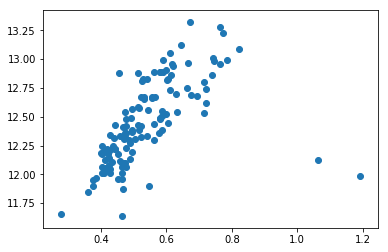

In [128]:
# this come from iterational model improvment. I was trying to understand why the model gives to the two points much better price
x_plot = X_train.loc[X_train['SaleCondition_Partial']==1, 'GrLivArea']
y_plot = y[X_train['SaleCondition_Partial']==1]
plt.scatter(x_plot, y_plot)

In [129]:
outliers_id = np.array([524, 1299])

outliers_id = outliers_id - 1 # id starts with 1, index starts with 0
X_train = X_train.drop(outliers_id)
y = y.drop(outliers_id)
# There are difinetly more outliers

In [130]:
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

def rmsle(y, y_pred):
     return np.sqrt((( (np.log1p(y_pred*price_scale)- np.log1p(y*price_scale)) )**2).mean())

# scorer = make_scorer(rmsle, False)
scorer = make_scorer(mean_squared_error, False)

def rmse_cv(model, X, y):
     return (cross_val_score(model, X, y, scoring=scorer)).mean()

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Learning ##
The model is sparse with n_features > n_samples. Likely it's linear.  It is classic case to use the Lasso model

In [132]:
from sklearn.ensemble import  BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error


clf={}
clf['GradientBoost_NB']=GradientBoostingRegressor(loss='lad', alpha=0.95,
                                n_estimators=500, subsample=.5,
                                learning_rate=.1, max_leaf_nodes=10
                                )
clf['GradientBoost_NB_2']=GradientBoostingRegressor(loss='lad',
                                n_estimators=500, subsample=.5,
                                learning_rate=.05, max_leaf_nodes=10
                                )
clf['GradientBoost_NB_3']=GradientBoostingRegressor(loss='lad',
                                n_estimators=1000, subsample=.5,
                                learning_rate=.05, max_leaf_nodes=10
                                )
clf['GradientBoost_NB_4']=GradientBoostingRegressor(loss='lad',
                                n_estimators=1000, subsample=.5,
                                learning_rate=.01, max_leaf_nodes=10)
clf['GradientBoost_NB_ls']=GradientBoostingRegressor(
                                n_estimators=500, subsample=.5,
                                learning_rate=.1, max_leaf_nodes=10
                                )
clf['GradientBoost_NB_5']=GradientBoostingRegressor(loss='lad',
                                n_estimators=500, subsample=.5,
                                learning_rate=.05, max_leaf_nodes=5
                                )

#clf['GaussianNB']=GaussianNB()

for key,obj in clf.items():
    scores= rmse_cv(obj,X_train,y)
    
    print(key,scores)
    obj.fit(X_train,y)

GradientBoost_NB -0.01580011311826052
GradientBoost_NB_2 -0.015614999448673216
GradientBoost_NB_3 -0.015459285684547642
GradientBoost_NB_4 -0.016193271096048095
GradientBoost_NB_ls -0.017128201718573748
GradientBoost_NB_5 -0.01568835866770667


## Getting results##

In [154]:
coef = pd.Series(clf['GradientBoost_NB_2'].feature_importances_, index = X_train.columns).sort_values()
imp_coef = coef[coef<=0]
new_train=X_train.drop(imp_coef.index,axis=1)
new_X_test=X_test.drop(imp_coef.index,axis=1)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Model")

ValueError: Wrong number of items passed 345, placement implies 466

In [150]:
imp_coef.index

Index(['Electrical_SBrkr', 'BldgType_2fmCon', 'BldgType_Twnhs',
       'HouseStyle_1.5Unf', 'HouseStyle_2.5Fin', 'SaleType_ConLD',
       'SaleType_Con', 'SaleType_CWD', 'RoofStyle_Mansard', 'RoofStyle_Shed',
       ...
       'garage_good_qu', 'LotShape_IR3', 'GrLivArea_Reconstruct',
       'BsmtUnfSF_exter_poor_qu', 'GarageArea_Reconstruct',
       'BsmtUnfSF_exter_poor_cond', 'GarageArea_garage_good_cond',
       'GarageArea_kitchen_poor_qu', 'garage_poor_cond',
       'MSSubClass_SubClass_40'],
      dtype='object', length=121)

Some features still look suspicious. May be, we need to exlude them like RoofMatl_ClyTile and others

In [152]:
for key,obj in clf.items():
    scores= rmse_cv(obj,new_train,y)
    
    print(key,scores)
    obj.fit(new_train,y)

GradientBoost_NB -0.016577345670685688
GradientBoost_NB_2 -0.01582724181759605
GradientBoost_NB_3 -0.015549435896891076
GradientBoost_NB_4 -0.016118875885518125
GradientBoost_NB_ls -0.016836462730197673
GradientBoost_NB_5 -0.015579148754602598


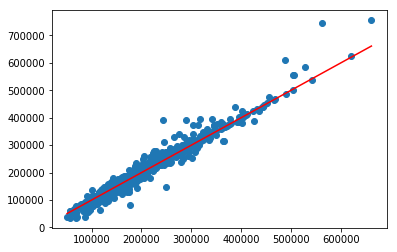

In [137]:
# This is a good way to see how model predict data
p_pred = np.expm1(clf['GradientBoost_NB_2'].predict(X_train))
plt.scatter(p_pred, np.expm1(y))
plt.plot([min(p_pred),max(p_pred)], [min(p_pred),max(p_pred)], c="red")

Some point are far from the red line. May be they are outliers like the 524th and the 1299th

In [162]:
# save to file to make a submission
new_X_test=X_test.drop(imp_coef.index,axis=1)
p = np.expm1(clf['GradientBoost_NB_ls'].predict(new_X_test))
solution = pd.DataFrame({"id":test.Id, "SalePrice":p}, columns=['id', 'SalePrice'])
solution.to_csv("submission.csv", index = False)

## Model improvement##
With various model tunnings I've got 0.11720 in public leaderboard. Ways of improvement are find some more outliers and exlude (or include) features.